In [90]:
# Importing all the necessary libraries
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import numpy as np
import math as math
import os
import seaborn as sns
from IPython.display import clear_output
from sklearn.neighbors import KernelDensity,KNeighborsClassifier
import os
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split
import pickle
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
import subprocess
import joblib
import requests
from PIL import Image
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from collections import Counter
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from astropy.io import fits
from specutils import Spectrum1D
from specutils.analysis import line_flux, centroid
from specutils.fitting import fit_generic_continuum
from astropy.io import fits
from astropy import units as u
from pyraf import iraf
import pyspeckit
from astropy.io import fits

from RVSNUpy.spectrum_import import sdss_fits
from RVSNUpy.rvm import rvm
from RVSNUpy.template import sdss_galaxy_templates
from RVSNUpy.spectrum_import import MMT_raw, sdss_fits

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)

SEED = 333
np.random.seed(SEED)

In [56]:
# Funções
def txt_to_specutils_nm_to_ang(caminho):
    df = pd.read_csv(caminho, sep='\t')

    x_data = df['wavelength']
    y_data = df['flux']

    # Criar um objeto Quantity para o comprimento de onda
    wavelength_quantity = x_data.values * u.Angstrom * 10

    # Criar um objeto Quantity para o fluxo com unidades apropriadas (por exemplo, erg/(cm^2*s*Angstrom))
    f_lamb_units = (u.erg / (u.cm**2 * u.s * u.Angstrom))
    flux_quantity = y_data.values*f_lamb_units

    # Criar um objeto Spectrum1D
    spectrum = Spectrum1D(flux=flux_quantity, spectral_axis=wavelength_quantity)
    
    return spectrum

def txt_to_specutils_angstron(caminho):
    df = pd.read_csv(caminho, sep='\t')

    x_data = df['wavelength']
    y_data = df['flux']

    # Criar um objeto Quantity para o comprimento de onda
    wavelength_quantity = x_data.values * u.Angstrom

    # Criar um objeto Quantity para o fluxo com unidades apropriadas (por exemplo, erg/(cm^2*s*Angstrom))
    f_lamb_units = (u.erg / (u.cm**2 * u.s * u.Angstrom))
    flux_quantity = y_data.values*f_lamb_units

    # Criar um objeto Spectrum1D
    spectrum = Spectrum1D(flux=flux_quantity, spectral_axis=wavelength_quantity)
    
    return spectrum


def spec_fits_to_ascii(caminho_fits):
    data_fits = fits.open(caminho_fits)
    spectra_init = data_fits[0].data

    #lambda = CRVAL1 + (x-CRPIX1)*CDELT1
    pix = np.linspace(1,data_fits[0].header['NAXIS1'],data_fits[0].header['NAXIS1'])
    lam = data_fits[0].header['CRVAL1'] + (pix-data_fits[0].header['CRPIX1'])*data_fits[0].header['CDELT1']

    # window_len = 5
    # kernel = np.ones(window_len, dtype=float)/window_len
    # gal_c = np.convolve(spectra_init, kernel, 'same')

    # gal_c[0] = spectra_init[0]
    # gal_c[1] = spectra_init[1]

    wavelength, flux = lam, spectra_init

    df_create = pd.DataFrame({'wavelength': wavelength, 'flux': flux})
    
    return df_create


def meus_espectros_para_rvsnu(wavelength, flux, uncertainty=None):
    """
    Converte seus espectros para o formato esperado pelo RVSNUpy
    
    Parameters:
    -----------
    wavelength : array
        Comprimento de onda em Angstroms
    flux : array  
        Fluxo (qualquer unidade)
    uncertainty : array, optional
        Incerteza no fluxo. Se None, será estimada
    
    Returns:
    --------
    spectrum : array (4, n_pixels)
        Espectro no formato RVSNUpy
    """
    
    # Garantir que são arrays numpy
    wavelength = np.array(wavelength)
    flux = np.array(flux)
    
    # Se não tem incerteza, estimar baseado no ruído do espectro
    if uncertainty is None:
        # Estimar incerteza como desvio padrão local
        from scipy.ndimage import uniform_filter1d
        smoothed = uniform_filter1d(flux, size=10)
        uncertainty = np.abs(flux - smoothed)
        uncertainty[uncertainty == 0] = np.nanstd(flux) * 0.1
    else:
        uncertainty = np.array(uncertainty)
    
    # Criar máscara (todos pixels válidos inicialmente)
    mask = np.ones_like(wavelength)
    
    # Mascarar pixels com problemas
    bad_pixels = (~np.isfinite(wavelength)) | (~np.isfinite(flux)) | (~np.isfinite(uncertainty))
    bad_pixels |= (uncertainty <= 0) | (flux == 0)
    mask[bad_pixels] = 0
    
    # Criar espectro no formato RVSNUpy
    spectrum = np.vstack([wavelength, flux, uncertainty, mask])
    
    return spectrum

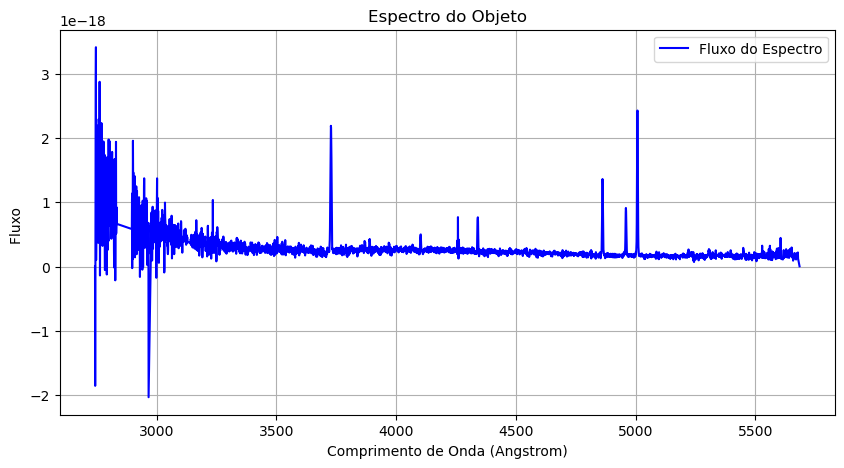

In [84]:
caminho_spec_fits = fr"/home/pierre/pierre/Documents/Faculdade_iag/Mestrado/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/Candidate1ac.fits"

df_spec = spec_fits_to_ascii(caminho_spec_fits)

wavelength = df_spec['wavelength'].values
flux = df_spec['flux'].values


# Fazer o gráfico do espectro
plt.figure(figsize=(10, 5))
plt.plot(wavelength, flux, color='blue', label='Fluxo do Espectro')
plt.xlabel('Comprimento de Onda (Angstrom)')
plt.ylabel('Fluxo ')
plt.title('Espectro do Objeto')
plt.legend()
plt.grid()
plt.show()


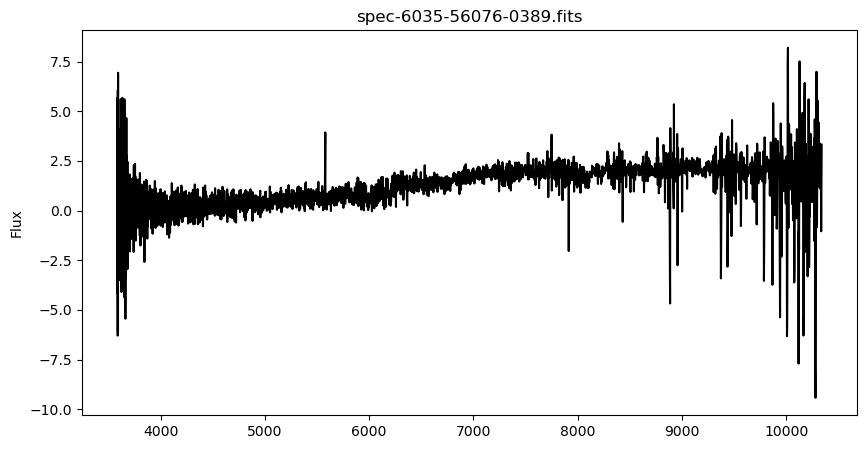

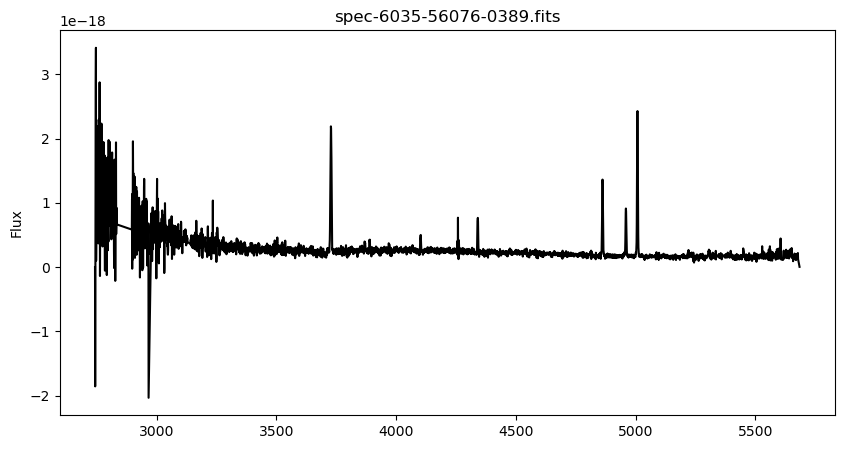

In [85]:
file = fr'/home/pierre/RVSNUpy/example/spectrum/spec-6035-56076-0389.fits'

# read wavelength, flux, and uncertainty data from the fits file
spec_rvsnu = meus_espectros_para_rvsnu(wavelength, flux)
spectrum = sdss_fits(file)

# plotting
plt.figure(figsize=(10, 5))
plt.plot(spectrum[0,:], spectrum[1,:], 'k-')
plt.ylabel('Flux')
plt.title(os.path.basename(file))
plt.show()

# plotting
plt.figure(figsize=(10, 5))
plt.plot(spec_rvsnu[0,:], spec_rvsnu[1,:], 'k-')
plt.ylabel('Flux')
plt.title(os.path.basename(file))
plt.show()

In [87]:
file = fr'/home/pierre/RVSNUpy/example/spectrum/spec-6035-56076-0389.fits'
spectrum = sdss_fits(file)

gal_temps = sdss_galaxy_templates()

# Corrija a ordem: primeiro os templates, depois outros parâmetros opcionais
measure = rvm(
    templates=gal_temps,
    z_range=[0.0, 0.4],           # Range de redshift
    temp_resolution=3,        # Resolução do template
    n_jobs=-1                 # Usar todos os cores
)


In [88]:
# Medição com opções
result = measure.z_single(
    spectrum,
    output='all',             # 'all' ou 'best'
    prior='em',              # 'abs' (absorção) ou 'em' (emissão)
    r_thres=5,               # Threshold do R-value
    chi_thres=4              # Threshold do chi-quadrado
)

print(result)

Empty DataFrame
Columns: [template_name, z, zerr, r, chi_eff, note]
Index: []


In [89]:
# Mesmo resultado que z_single com output='all'
result = measure.z_all_templates(spectrum)
print(result)

Empty DataFrame
Columns: [template_name, z, zerr, r, chi_eff, note]
Index: []


In [83]:
# Ver todos os templates e resultados
all_results = measure.z_single(spectrum, output='all')

# Filtrar apenas os bons resultados
good_results = all_results[all_results['r'] > 5]  # r > 5 indica boa correlação

# Ver o melhor resultado
best_result = all_results[all_results['note'] == 'best']

# Ordenar por r-value (melhor correlação primeiro)
sorted_results = all_results.sort_values('r', ascending=False)

print("Melhor template:", best_result['template_name'].iloc[0])
print("Redshift:", best_result['z'].iloc[0])
print("Qualidade (r):", best_result['r'].iloc[0])

IndexError: single positional indexer is out-of-bounds

# Pyraf 

In [102]:
from pyraf import iraf

# Exemplo de como usar splot com extensão específica
caminho_arquivo = "/home/pierre/pierre/Documents/Faculdade_iag/Mestrado/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/angstons/Candidate2_ang.fits"

# Formas corretas de especificar extensões:
# Para extensão por nome:
iraf.splot(f"{caminho_arquivo}[SCI]")  # ou [SCIENCE]


Can't get image /home/pierre/pierre/Documents/Faculdade_iag/Mestrado/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/angstons/Candidate2_ang.fits[SCI]


In [104]:
import subprocess
import pandas as pd

def run_alfa(fitsfile):
    proc = subprocess.run(['alfa', fitsfile], capture_output=True, text=True)
    # Parse alfa_output.txt e transforme em DataFrame
    return df


# Pyneb

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt

In [2]:
import pyneb as pn
O3 = pn.Atom('O', 3)

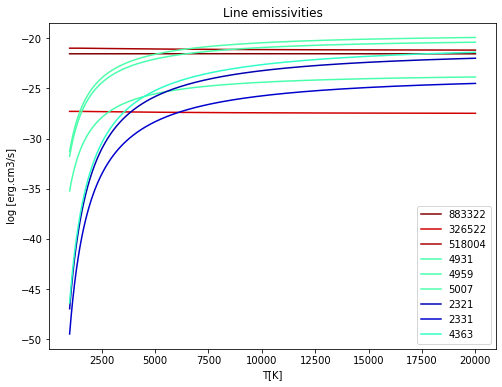

In [5]:
f, ax = plt.subplots(figsize=(8, 6))
O3.plotEmiss(tem_min=1000, tem_max=20000, ionic_abund=1.0, den=1e3, style='-', 
             legend_loc=4, temLog=False, plot_total=False, plot_only_total=False, 
             legend=True, total_color='black', total_label='TOTAL', ax=ax)

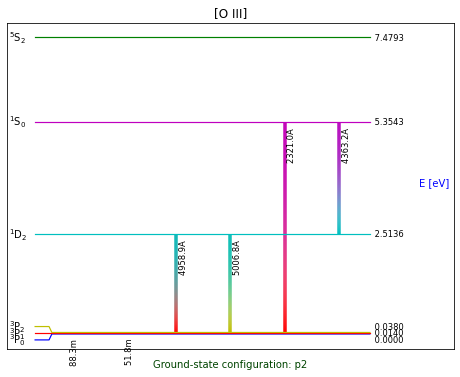

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
O3.plotGrotrian(tem=1e4, den=1e2, thresh_int=1e-3, unit = 'eV', ax=ax)

In [28]:
import numpy as np

# Fluxo #

OII = 1
Hb = 22.39
OIII = 59.49


# EQW_medido #

OII_eq = -1
Hb_eq = -26.4
OIII_eq = -55.63

x = 0.11 / ( ( np.log10(OII/Hb) ) + 0.85 )
y = np.log10(OIII/Hb)

x_2 =  0.11 / ( ( np.log10(OII_eq/Hb_eq) ) + 0.85 )
y_2 = np.log10(OIII_eq/Hb_eq)

print(f"x2: {x_2:.3f}, y: {y:.3f}, x: {x_2:.3f}, y_2: {y_2:.3f}")

x2: -0.192, y: 0.424, x: -0.192, y_2: 0.324
